## Создание искусственного датасета MNIST

- y_1 – оригинальная цифра (от 0 до 9);
- y_2 – отражена цифра или нет;
- y_0 – основная искусственная метка, которую надо предсказать (`Y`), равна 1 для чётных неперевёрнутых или нечётных перевёрнутых, для остальных равна 0.

In [1]:
import torch
import torchvision
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
class CustomMNISTDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.data = []

        for idx in range(len(mnist_dataset)):
            image, label = mnist_dataset[idx]

            # Создаем новое изображение размером 84x84
            new_image = torch.zeros(84, 84)

            # Добавляем шум к фону
            noise = torch.randn(84, 84) * 0.05  # шум со средним значением 0 и стандартным отклонением 0.1
            new_image += noise

            # Определяем, будет ли изображение отражено по вертикали
            flip = 0 if label in [0, 1, 8] else random.choice([1, 0])

            # Исходное изображение помещается в центр нового изображения
            if flip:
                new_image[28:56, 28:56] = torch.flip(image, dims=[2])
            else:
                new_image[28:56, 28:56] = image.squeeze()

            # Определяем y_0
            y_0 = 1 if (label % 2 == 0 and not flip) or (label % 2 != 0 and flip) else 0

            self.data.append((new_image, label, int(flip), y_0))

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        return self.data[idx]

In [3]:
# Загружаем исходный датасет MNIST
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 258198949.49it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 7881820.15it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 105457325.35it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 13549451.47it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



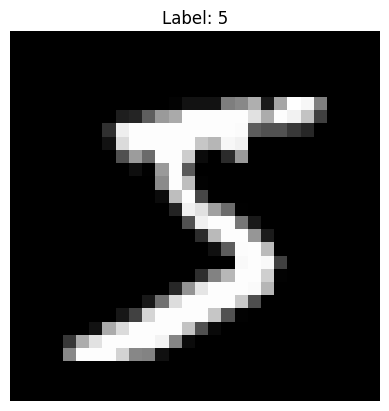

In [4]:
# Выбираем индекс изображения для отображения (например, первое изображение с индексом 0)
image, label = mnist_dataset[0]

# Преобразуем тензор изображения в формат (28, 28)
image = image.squeeze().numpy()

# Отображаем изображение и его метку
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [5]:
# Создаем экземпляр кастомного датасета
custom_dataset = CustomMNISTDataset(mnist_dataset)

In [6]:
# Сохраняем кастомный датасет с помощью torch.save
torch.save(custom_dataset, '/content/drive/MyDrive/custom_dataset.pth')

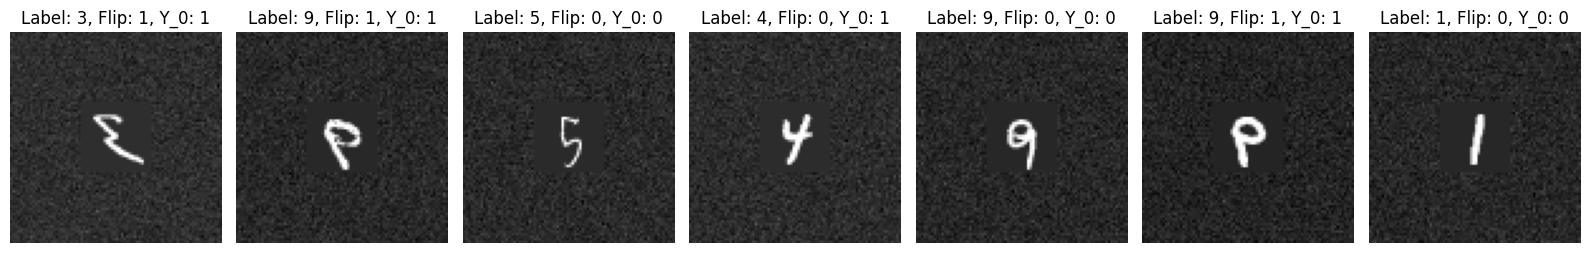

In [ ]:
# Загружаем кастомный датасет из файла
custom_dataset_loaded = torch.load('/content/drive/MyDrive/custom_dataset.pth')

# Создаем DataLoader для загруженного кастомного датасета
dataloader = DataLoader(custom_dataset_loaded, batch_size=7, shuffle=True)

# Выводим несколько примеров из загруженного кастомного датасета
for images, labels, flips, y_0 in dataloader:
    # Выводим изображения и их метки
    fig, axes = plt.subplots(1, len(images), figsize=(16, 4))
    for ax, image, label, flip, y_0 in zip(axes, images, labels, flips, y_0):
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Label: {label.item()}, Flip: {flip}, Y_0: {y_0}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    break  # прерываем цикл после первой итерации для примера

## Автоэнкодер

In [57]:
# Подготовка данных для обучения автоэнкодера
class CustomPatchesDataset(Dataset):
    def __init__(self, custom_dataset, patch_size):
        self.custom_dataset = custom_dataset
        self.patch_size = patch_size
        self.data = []

        for idx in range(len(custom_dataset)):
            image, label, flip, y_0 = custom_dataset[idx]

            # Создаем патчи изображений
            num_horizontal_patches = image.size(1) // self.patch_size
            num_vertical_patches = image.size(0) // self.patch_size

            patches = []
            for i in range(num_horizontal_patches):
                for j in range(num_vertical_patches):
                    #patch = image[i*self.patch_size:(i+1)*self.patch_size, j*self.patch_size:(j+1)*self.patch_size].reshape(-1)  # Используем reshape для изменения формы
                    patch = image[i*self.patch_size:(i+1)*self.patch_size, j*self.patch_size:(j+1)*self.patch_size]
                    patch = patch.unsqueeze(0)
                    patches.append(patch)

            # Создаем вектор концептов
            concepts_vector = torch.tensor([label, flip, y_0])

            self.data.append((torch.stack(patches), concepts_vector))

    def __len__(self):
        return len(self.custom_dataset)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
# Определение класса автоэнкодера
class Autoencoder(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, embedding_size)
        self.decoder = nn.Linear(embedding_size, input_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Разворачиваем входные данные
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [8]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [49]:
class Autoencoder(nn.Module):
    def __init__(self, encoded_space_dim, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(encoded_space_dim, input_dim)
        self.decoder = Decoder(encoded_space_dim, input_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [50]:
### Define the loss function
loss_fn = nn.MSELoss()

### Set the random seed for reproducible results
torch.manual_seed(0)

autoencoder = Autoencoder(encoded_space_dim=4,input_dim=128)

optim = torch.optim.Adam(autoencoder.parameters(), lr=0.001, weight_decay=1e-05)

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

In [10]:
# Параметры обучения
patch_size = 28 #21
patch_count = 9 #16
input_size = patch_size*patch_size  # Размер входа (размер одного патча)
embedding_size = 64  # Размер эмбеддинга

In [11]:
# Загружаем измененный датасет
custom_dataset = torch.load('/content/drive/MyDrive/custom_dataset.pth')

In [12]:
# Определение размеров тренировочного и тестового наборов
train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size

# Разделение набора данных на тренировочный и тестовый
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

# Вывод размеров тренировочного и тестового наборов
print(f"Размер тренировочного набора: {len(train_dataset)}")
print(f"Размер тестового набора: {len(test_dataset)}")

Размер тренировочного набора: 48000
Размер тестового набора: 12000


In [58]:
# Создаем DataLoader для кастомного датасета с патчами
patches_dataset = CustomPatchesDataset(train_dataset, patch_size=patch_size)
dataloader = DataLoader(patches_dataset, batch_size=256, shuffle=True)

In [ ]:
# Создаем экземпляр автоэнкодера
autoencoder = Autoencoder(input_size, embedding_size)

# Определяем функцию потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

In [51]:
### Training function
def train_epoch_den(autoencoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    autoencoder.encoder.train()
    autoencoder.decoder.train()
    train_loss = []

    for patches, _ in dataloader:
        #patches = patches.to(device)
        encoded, decoded = autoencoder(patches)

        # Evaluate loss
        loss = loss_fn(decoded, patches)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [ ]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

In [59]:
num_epochs = 30
diz_loss = {'train_loss':[]}
for epoch in range(num_epochs):
   train_loss = train_epoch_den(autoencoder,device,dataloader,loss_fn,optim)
   print('\n EPOCH {}/{} \t train loss {}'.format(epoch + 1, num_epochs,train_loss))
   diz_loss['train_loss'].append(train_loss)
   #plot_ae_outputs(encoder,decoder,n=10)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [256, 9, 1, 28, 28]

In [60]:
# Обучение модели
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    for batch in dataloader:
        inputs, _ = batch
        inputs = inputs.to(device)

        optim.zero_grad()
        encoded, decoded = autoencoder(inputs)
        loss = loss_fn(decoded, inputs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

print('Training Finished')

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [256, 9, 1, 28, 28]

## Обучение автоэнкодера

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    for patches, _ in dataloader:  # Получаем также индексы изображений
        # Прямой проход
        embeddings, outputs = autoencoder(patches.view(-1, input_size))

        # Рассчитываем потери
        loss = criterion(outputs, patches.view(-1, input_size))

        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Обновляем общие обучающие потери
        train_loss += loss.item() * patches.size(0)

    # Выводим средние обучающие статистики
    train_loss = train_loss / len(dataloader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0035
Epoch [2/10], Loss: 0.0033
Epoch [3/10], Loss: 0.0032
Epoch [4/10], Loss: 0.0032
Epoch [5/10], Loss: 0.0032
Epoch [6/10], Loss: 0.0032
Epoch [7/10], Loss: 0.0031
Epoch [8/10], Loss: 0.0032
Epoch [9/10], Loss: 0.0032
Epoch [10/10], Loss: 0.0031


In [ ]:
# Получаем эмбеддинги для каждого патча изображений
embeddings_list = []
indexes_list = []
idxs = 0
for patches, concepts_vector in patches_dataset:
    with torch.no_grad():
        embeddings_batch, _ = autoencoder(patches.view(-1, input_size))
    embeddings_list.append(embeddings_batch)
    for i in range(patch_count):
      indexes_list.append(idxs)
    idxs += 1
embeddings = torch.cat(embeddings_list)
indexes = torch.tensor(indexes_list)

tensor([[ 0.0292, -0.0332,  0.0263,  ..., -0.0266,  0.0072, -0.0541],
        [ 0.0292, -0.0332,  0.0263,  ..., -0.0266,  0.0072, -0.0541],
        [ 0.0292, -0.0332,  0.0263,  ..., -0.0266,  0.0072, -0.0541],
        ...,
        [ 0.0296, -0.0293,  0.0005,  ...,  0.0049, -0.0093, -0.0519],
        [ 0.0296, -0.0293,  0.0005,  ...,  0.0049, -0.0093, -0.0519],
        [ 0.0296, -0.0293,  0.0005,  ...,  0.0049, -0.0093, -0.0519]])


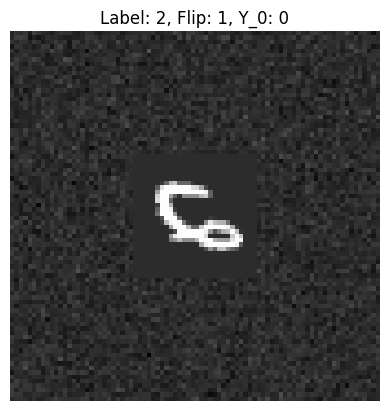

In [ ]:
# Пример получения изображения и меток, соответствующих определенному эмбеддингу
index = 0  # Например, первый эмбеддинг
image, label, flip, y_0 = train_dataset[indexes[index]]
print(embeddings[indexes])
# Выводим изображение
plt.imshow(image.squeeze().detach().numpy(), cmap='gray')
plt.title(f'Label: {label}, Flip: {flip}, Y_0: {y_0}')
plt.axis('off')  # Убираем оси координат
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
# Нормализация данных
##scaler = StandardScaler() ##
##normalized_embeddings = scaler.fit_transform(embeddings.numpy()) ##

# Выбор оптимального количества кластеров с использованием метода локтя
inertia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)

# Отрисовка графика для метода локтя
import matplotlib.pyplot as plt
plt.plot(range(1, 20), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

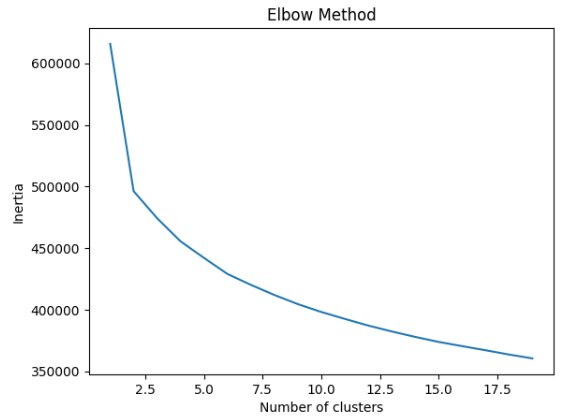

In [ ]:
from sklearn.cluster import KMeans

# Количество кластеров R (подбирается вами)
R = 16

# Создаем объект KMeans
kmeans = KMeans(n_clusters=R)

# Обучаем модель на эмбеддингах
kmeans.fit(embeddings.numpy())  # Преобразуем тензор embeddings в массив numpy

# Получаем метки кластеров для каждого эмбеддинга
cluster_labels = kmeans.labels_

# Печатаем количество эмбеддингов в каждом кластере
for cluster in range(R):
    print(f"Количество эмбеддингов в кластере {cluster}: {sum(cluster_labels == cluster)}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Количество эмбеддингов в кластере 0: 384418
Количество эмбеддингов в кластере 1: 4053
Количество эмбеддингов в кластере 2: 2136
Количество эмбеддингов в кластере 3: 1760
Количество эмбеддингов в кластере 4: 3800
Количество эмбеддингов в кластере 5: 2158
Количество эмбеддингов в кластере 6: 4426
Количество эмбеддингов в кластере 7: 2996
Количество эмбеддингов в кластере 8: 3592
Количество эмбеддингов в кластере 9: 3463
Количество эмбеддингов в кластере 10: 3549
Количество эмбеддингов в кластере 11: 2340
Количество эмбеддингов в кластере 12: 3732
Количество эмбеддингов в кластере 13: 2163
Количество эмбеддингов в кластере 14: 3481
Количество эмбеддингов в кластере 15: 3933


Изображения в кластере 0:


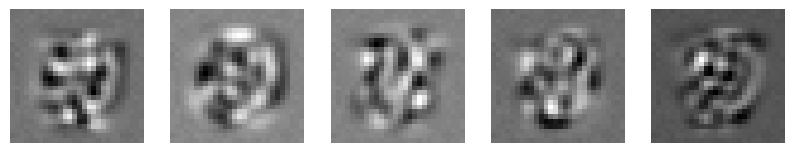

Изображения в кластере 1:


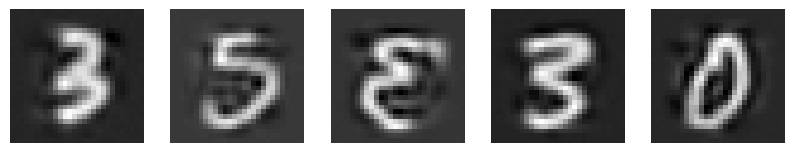

Изображения в кластере 2:


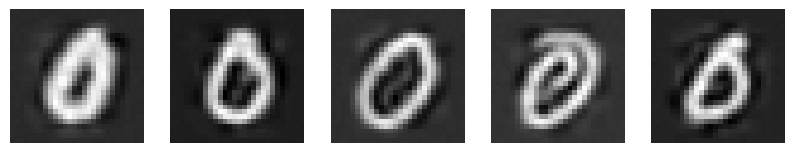

Изображения в кластере 3:


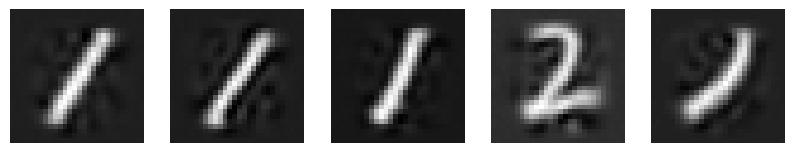

Изображения в кластере 4:


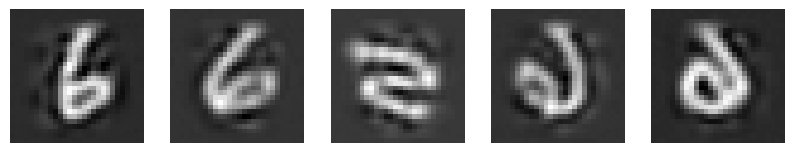

Изображения в кластере 5:


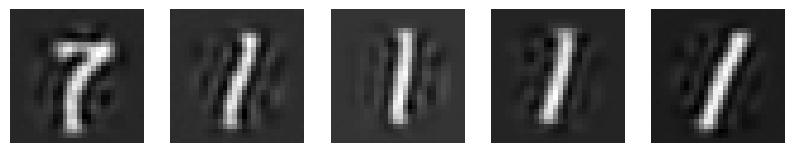

Изображения в кластере 6:


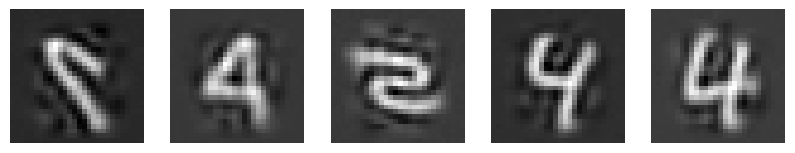

Изображения в кластере 7:


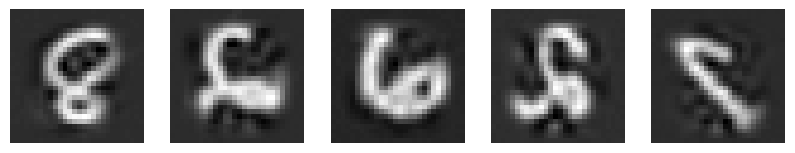

Изображения в кластере 8:


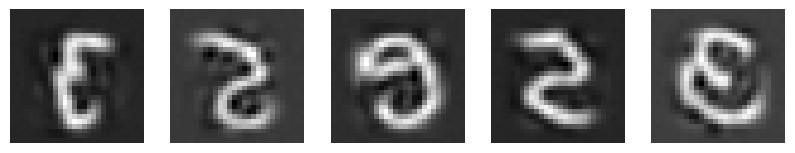

Изображения в кластере 9:


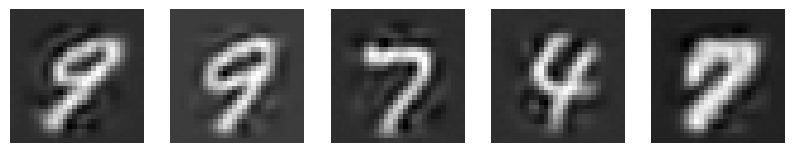

Изображения в кластере 10:


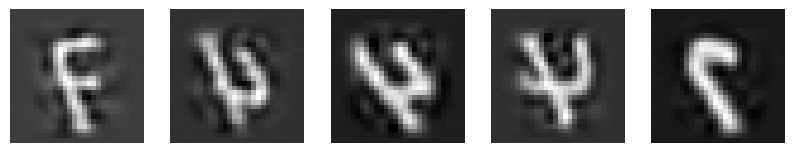

Изображения в кластере 11:


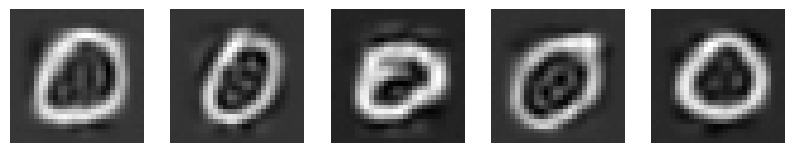

Изображения в кластере 12:


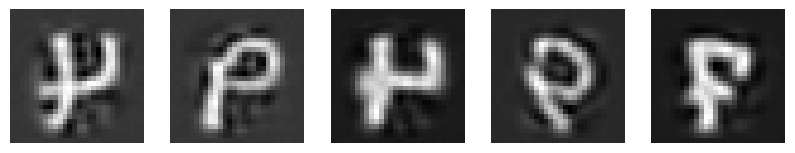

Изображения в кластере 13:


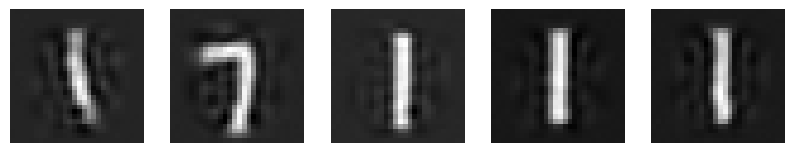

Изображения в кластере 14:


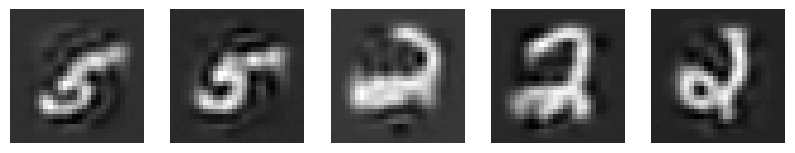

Изображения в кластере 15:


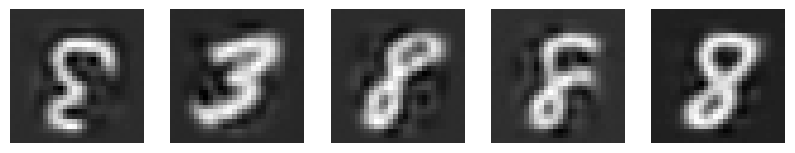

In [ ]:
# Печатаем изображения из каждого кластера
for cluster in range(R):
    # Получаем индексы изображений, попавших в текущий кластер
    cluster_indexes = np.where(cluster_labels == cluster)[0]  # Возвращаемый tuple содержит массив индексов, поэтому выбираем первый элемент

    # Проверяем, что в кластере есть изображения
    if len(cluster_indexes) > 0:
        # Выбираем несколько случайных изображений из текущего кластера
        random_image_indexes = np.random.choice(cluster_indexes, 5, replace=False)

        # Печатаем каждое изображение из текущего кластера
        print(f"Изображения в кластере {cluster}:")
        plt.figure(figsize=(10, 2))  # Устанавливаем размер фигуры

        for i, index in enumerate(random_image_indexes, 1):
          plt.subplot(1, 5, i)  # Создаем subplot в одном ряду
          image, label, flip, y_0 = train_dataset[indexes[index]]
          # Передача эмбеддинга через декодер
          decoded_image = autoencoder.decoder(embeddings[index])
          decoded_image = decoded_image.reshape(patch_size, patch_size)

          # Вывод изображения
          plt.imshow(decoded_image.squeeze().detach().numpy(), cmap='gray')
          plt.axis('off')  # Убираем оси координат
        plt.show()
    else:
        print(f"В кластере {cluster} нет изображений")

### Вероятности

* concept_count - количество изображений, соответствующих каждому концепту
* concept_prior - априорные вероятности Pr{C^(t) = v}
* cluster_counts - количесвто эмбедингов, попавших в каждый кластер
* concept_cond - условные вероятности Pr{e ∈ K_l | C^(t) = v}
* concept_post - апостериорные вероятности Pr{C^(t) = v | e ∈ K_l}


In [ ]:
concept_len = {'y_0': 2, 'y_1': 10, 'y_2': 2}

In [ ]:
concept_values = {'y_0': [0, 1], 'y_1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'y_2': [0, 1]}

In [ ]:
# Создаем счетчики для каждого концепта
concept_count = {
    "y_1": [0] * 10,  # Для y_1 от 0 до 9
    "y_2": [0, 0],     # Для y_2 - отражена или нет
    "y_0": [0, 0]      # Для y_0 - равна 1 или 0
}

# Проходим по всем изображениям в датасете
for image, label, flip, y_0 in train_dataset:
    # Увеличиваем счетчики в соответствии с концептами
    concept_count["y_1"][label] += 1  # Для y_1 используем метку (label)
    concept_count["y_2"][flip] += 1  # Для y_2 используем значение flip (отражено или нет)
    concept_count["y_0"][y_0] += 1  # Для y_0 используем значение y_0 (равна 1 или 0)

# Выводим результат
print("Количество изображений, соответствующих каждому концепту:")
print(concept_count)

Количество изображений, соответствующих каждому концепту:
{'y_1': [4745, 5371, 4752, 4906, 4668, 4314, 4766, 5010, 4689, 4779], 'y_2': [31472, 16528], 'y_0': [21942, 26058]}


In [ ]:
concept_prior = concept_count.copy()
len_dataset = len(train_dataset)

# Вычислить априорные вероятности Pr{C^(t) = v}
for concept in concept_prior:
    #concept_prior[concept] = [round(value / len_dataset, 6) for value in concept_prior[concept]]
    concept_prior[concept] = [value / len_dataset for value in concept_prior[concept]]

print("Априорные вероятности:")
print(concept_prior)

Априорные вероятности:
{'y_1': [0.09885416666666667, 0.11189583333333333, 0.099, 0.10220833333333333, 0.09725, 0.089875, 0.09929166666666667, 0.104375, 0.0976875, 0.0995625], 'y_2': [0.6556666666666666, 0.3443333333333333], 'y_0': [0.457125, 0.542875]}


In [ ]:
# Посчитать количество эмбеддингов, попавших в каждый кластер S_1, S_2, ..., S_R
cluster_counts = {cluster: sum(cluster_labels == cluster) for cluster in range(R)}
cluster_counts

{0: 384418,
 1: 4053,
 2: 2136,
 3: 1760,
 4: 3800,
 5: 2158,
 6: 4426,
 7: 2996,
 8: 3592,
 9: 3463,
 10: 3549,
 11: 2340,
 12: 3732,
 13: 2163,
 14: 3481,
 15: 3933}

In [ ]:
# Вычислить условные вероятности Pr{e ∈ K_l | C^(t) = v}
concept_cond = {
    "y_1": [[0] * 10 for _ in range(R)],
    "y_2": [[0, 0] for _ in range(R)],
    "y_0": [[0, 0] for _ in range(R)]
}

In [ ]:
concept_count

{'y_1': [4745, 5371, 4752, 4906, 4668, 4314, 4766, 5010, 4689, 4779],
 'y_2': [31472, 16528],
 'y_0': [21942, 26058]}

In [ ]:
# Количество эмбедингов, соответствующих каждому концепту
embedding_count = {concept: [value_item * patch_count for value_item in values] for concept, values in concept_count.items()}

embedding_count

{'y_1': [42705, 48339, 42768, 44154, 42012, 38826, 42894, 45090, 42201, 43011],
 'y_2': [283248, 148752],
 'y_0': [197478, 234522]}

In [ ]:
for cluster in range(R):
    # Получаем индексы эмбедингов, попавших в текущий кластер
    cluster_indexes = np.where(cluster_labels == cluster)[0]  # Возвращаемый tuple содержит массив индексов, поэтому выбираем первый элемент

    for index in cluster_indexes:
      _, y_1, y_2, y_0 = train_dataset[indexes[index]]
      concept_cond['y_0'][cluster][y_0] += 1
      concept_cond['y_1'][cluster][y_1] += 1
      concept_cond['y_2'][cluster][y_2] += 1

In [ ]:
concept_cond

{'y_1': [[37988,
   42986,
   38061,
   39288,
   37375,
   34638,
   38171,
   40135,
   37527,
   38249],
  [169, 5, 108, 1990, 1, 1028, 36, 0, 665, 51],
  [1888, 0, 33, 32, 5, 99, 44, 5, 11, 19],
  [1, 1504, 105, 4, 27, 12, 10, 48, 39, 10],
  [111, 11, 181, 88, 100, 270, 3001, 2, 32, 4],
  [0, 1909, 46, 15, 20, 16, 22, 53, 70, 7],
  [8, 19, 105, 112, 1592, 301, 19, 853, 149, 1268],
  [29, 8, 2141, 139, 39, 56, 467, 22, 71, 24],
  [84, 1, 185, 1738, 1, 1137, 31, 2, 367, 46],
  [6, 11, 35, 38, 666, 120, 2, 1514, 109, 962],
  [2, 0, 45, 42, 631, 161, 4, 1579, 71, 1014],
  [2163, 0, 13, 24, 2, 22, 39, 19, 14, 44],
  [22, 1, 55, 70, 1303, 183, 4, 773, 136, 1185],
  [0, 1868, 29, 41, 19, 43, 43, 40, 52, 28],
  [182, 11, 1333, 165, 220, 386, 974, 26, 115, 69],
  [52, 5, 293, 368, 11, 354, 27, 19, 2773, 31]],
 'y_2': [[251994, 132424],
  [3305, 748],
  [2088, 48],
  [1757, 3],
  [1911, 1889],
  [2143, 15],
  [3827, 599],
  [1093, 1903],
  [936, 2656],
  [3399, 64],
  [128, 3421],
  [2246, 9

In [ ]:
# условные вероятности
for t in ["y_0", "y_1", "y_2"]:
    for v in range(concept_len[t]):
        for cluster in range(R):
            if embedding_count[t][v] != 0:
                #concept_cond[t][cluster][v] = round(concept_cond[t][cluster][v] / embedding_count[t][v], 6)
                concept_cond[t][cluster][v] = concept_cond[t][cluster][v] / embedding_count[t][v]
            else:
                concept_cond[t][cluster][v] = 0

print("Условные вероятности:")
concept_cond

Условные вероятности:


{'y_1': [[0.8895445498185224,
   0.889261259024804,
   0.8899410774410774,
   0.8897948090773203,
   0.8896267733028659,
   0.8921341369185597,
   0.8898913600969832,
   0.8901086715457973,
   0.8892443307030639,
   0.8892841366162144],
  [0.0039573820395738205,
   0.00010343614886530545,
   0.0025252525252525255,
   0.04506952937446211,
   2.3802723031514804e-05,
   0.0264771029722351,
   0.000839278220730172,
   0.0,
   0.015757920428425866,
   0.0011857431819767036],
  [0.044210279826718185,
   0.0,
   0.0007716049382716049,
   0.0007247361507451193,
   0.00011901361515757403,
   0.0025498377375985167,
   0.0010257844920035437,
   0.00011088933244621867,
   0.0002606573303950143,
   0.00044174745995210525],
  [2.3416461772626156e-05,
   0.031113593578683877,
   0.0024551066217732885,
   9.059201884313991e-05,
   0.0006426735218508997,
   0.0003090712409210323,
   0.00023313283909171445,
   0.0010645375914836992,
   0.0009241487168550509,
   0.00023249866313268698],
  [0.002599227256

In [ ]:
# Вычислить постериорные вероятности  Pr{C^(t) = v | e ∈ K_l}
concept_post = {
    "y_1": [[0] * 10 for _ in range(R)],
    "y_2": [[0, 0] for _ in range(R)],
    "y_0": [[0, 0] for _ in range(R)]
}

In [ ]:
# Вероятность попадания эмбединга в кластер
#cluster_counts_pr = {concept: round(values / len(embeddings), 6) for concept, values in cluster_counts.items()}
cluster_counts_pr = {concept: values / len(embeddings) for concept, values in cluster_counts.items()}
cluster_counts_pr

{0: 0.8898564814814814,
 1: 0.009381944444444444,
 2: 0.004944444444444444,
 3: 0.004074074074074074,
 4: 0.008796296296296297,
 5: 0.0049953703703703705,
 6: 0.01024537037037037,
 7: 0.006935185185185185,
 8: 0.008314814814814815,
 9: 0.008016203703703704,
 10: 0.008215277777777778,
 11: 0.005416666666666667,
 12: 0.008638888888888889,
 13: 0.005006944444444444,
 14: 0.00805787037037037,
 15: 0.009104166666666667}

In [ ]:
# Вычисление условных вероятностей Pr{C^(t) = v | e ∈ K_l}
for cluster in range(R):
  for t in ["y_0", "y_1", "y_2"]:
    total_prob = 0
    for v in range(concept_len[t]):
      # Вычисляем числитель: Pr{e ∈ K_l | C^(t) = v} * Pr{C^(t) = v}
      numerator = concept_cond[t][cluster][v] * concept_prior[t][v]

      # Вычисляем условную вероятность Pr{C^(t) = v | e ∈ K_l}
      #concept_post[t][cluster][v] = numerator if cluster_counts[cluster] != 0 else 0.0
      concept_post[t][cluster][v] = numerator

      # Вычисление безусловной вероятности Pr {s}
      total_prob += concept_post[t][cluster][v]

    for v in range(concept_len[t]):
      # Нормализация вероятностей, чтобы их сумма была равна 1
      #concept_post[t][cluster][v] = round(concept_post[t][cluster][v] / total_prob, 6)
      concept_post[t][cluster][v] = concept_post[t][cluster][v] / total_prob

concept_post

{'y_1': [[0.09881951417467445,
   0.11182098653028735,
   0.09900941163004855,
   0.10220124968133648,
   0.09722489581653306,
   0.09010504190750693,
   0.09929555848061225,
   0.10440458043067703,
   0.09762029873731198,
   0.09949846261101196],
  [0.04169750801875154,
   0.001233654083395016,
   0.026646928201332354,
   0.4909943251912164,
   0.0002467308166790032,
   0.2536392795460153,
   0.008882309400444115,
   0.0,
   0.16407599309153711,
   0.012583271650629162],
  [0.883895131086142,
   0.0,
   0.015449438202247184,
   0.014981273408239694,
   0.0023408239700374524,
   0.046348314606741554,
   0.02059925093632958,
   0.002340823970037452,
   0.005149812734082395,
   0.008895131086142318],
  [0.0005681818181818184,
   0.8545454545454547,
   0.05965909090909093,
   0.0022727272727272735,
   0.015340909090909096,
   0.0068181818181818205,
   0.005681818181818183,
   0.02727272727272728,
   0.022159090909090916,
   0.005681818181818183],
  [0.029210526315789475,
   0.002894736842

### Работа с тестовыми данными

In [ ]:
patches_dataset_test = CustomPatchesDataset(test_dataset, patch_size=patch_size)

In [ ]:
# Получаем эмбеддинги для каждого патча тестовых изображений
embeddings_list_test = []
indexes_list_test = []
idxs = 0
for patches, concepts_vector in patches_dataset_test:
    with torch.no_grad():
        embeddings_batch, _ = autoencoder(patches.view(-1, input_size))
    embeddings_list_test.append(embeddings_batch)
    for i in range(patch_count):
      indexes_list_test.append(idxs)
    idxs += 1
embeddings_test = torch.cat(embeddings_list_test)
indexes_test = torch.tensor(indexes_list_test)

In [ ]:
cluster_centers = kmeans.cluster_centers_

In [ ]:
def assign_embeddings_to_clusters(embeddings, cluster_centers, num_clusters):
    # Преобразуем cluster_centers в тензор PyTorch
    cluster_centers_tensor = torch.tensor(cluster_centers, dtype=torch.float32)

    # Вычисляем расстояния между эмбеддингами и центрами кластеров
    distances = torch.cdist(embeddings, cluster_centers_tensor)

    # Находим индексы кластеров с минимальными расстояниями для каждого эмбеддинга
    _, cluster_indices = torch.min(distances, dim=1)

    s = [0] * num_clusters
    for cluster_index in cluster_indices:
        s[cluster_index] += 1

    return s

In [ ]:
s = assign_embeddings_to_clusters(embeddings_test[0:patch_count], cluster_centers, R)

In [ ]:
s

[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

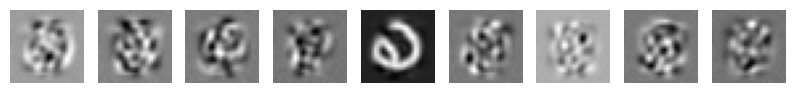

In [ ]:
# Печатаем каждое изображение из текущего кластера
plt.figure(figsize=(10, 2))  # Устанавливаем размер фигуры

for i, index in enumerate(range(patch_count)):
  plt.subplot(1, patch_count, i+1)  # Создаем subplot в одном ряду
  # Передача эмбеддинга через декодер
  decoded_image = autoencoder.decoder(embeddings_test[index])
  decoded_image = decoded_image.reshape(patch_size, patch_size)

  # Вывод изображения
  plt.imshow(decoded_image.squeeze().detach().numpy(), cmap='gray')
  plt.axis('off')  # Убираем оси координат

plt.show()

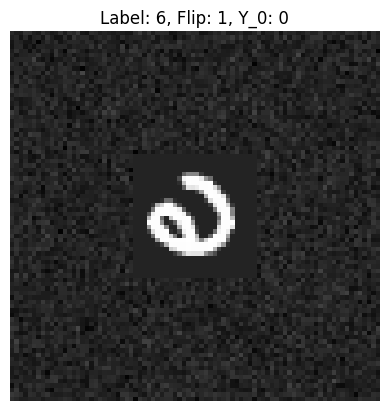

In [ ]:
image, label, flip, y_0 = test_dataset[indexes_test[0]]
# Выводим изображение
plt.imshow(image.squeeze().detach().numpy(), cmap='gray')
plt.title(f'Label: {label}, Flip: {flip}, Y_0: {y_0}')
plt.axis('off')  # Убираем оси координат
plt.show()

In [ ]:
e = 0.00000001

In [ ]:
def compute_concept_probabilities(s, concept_probabilities, prior_prob, conditional_prob):
    concepts = list(concept_probabilities.keys())
    total_embeddings = sum(s)

    multinomial_coefficient = math.factorial(total_embeddings) / math.prod(math.factorial(count) for count in s)

    # Вычисляем апостериорные вероятности для каждого концепта
    for t in concepts:
        # Вычисляем условную вероятность P(s, p(t, v))
        for v in range(len(prior_prob[t])):
            concept_probability = 1.0
            p_t_v = [conditional_prob[t][i][v] for i in range(len(s))]

            concept_probability *= multinomial_coefficient
            for p, count in zip(p_t_v, s):
              if p == 0.0:
                p = e
              concept_probability *= (p ** count)

            # Учитываем априорную вероятность Pr{C^(t) = v}
            concept_probability *= prior_prob[t][v]
            #concept_probabilities[t][v] = round(concept_probability, 6)
            concept_probabilities[t][v] = concept_probability

        # Вычисление безусловной вероятности Pr {s}
        total_prob  = sum(concept_probabilities[t][v] for v in range(len(prior_prob[t])))

        for v in range(len(prior_prob[t])):
          # Нормализация вероятностей, чтобы их сумма была равна 1
          #concept_probabilities[t][v] = round(concept_probabilities[t][v] / total_prob, 6)
          concept_probabilities[t][v] = concept_probabilities[t][v] / total_prob

    return concept_probabilities

In [ ]:
concept_test = {
    "y_1": [1] * 10,   # Для y_1 от 0 до 9
    "y_2": [1, 1],     # Для y_2 - отражена или нет
    "y_0": [1, 1]      # Для y_0 - равна 1 или 0
}

In [ ]:
test = compute_concept_probabilities(s, concept_test, concept_prior, concept_cond)
test

{'y_1': [0.924083411237452,
  2.0598977901230633e-07,
  0.005573736163727087,
  0.010276452372541059,
  0.0008550780957297069,
  0.009620042081489527,
  0.016713736791634272,
  0.008158510683378644,
  0.00596499255197051,
  0.018753834032298376],
 'y_2': [0.9596293318880736, 0.040370668111926404],
 'y_0': [0.01923222718553882, 0.9807677728144611]}

In [ ]:
# Выбор значения концепта с наибольшей вероятностью, превышающей порог
pred_concept = {}
true_concept = {}

for concept, probs in test.items():
  max_prob_index = torch.argmax(torch.tensor(probs))
  pred_concept[concept] = max_prob_index.item()

# Получение настоящих концептов
_, label, flip, y_0 = test_dataset[0]
true_concept = {'y_1': label, 'y_2': flip, 'y_0': y_0}

print("Предсказанные концепты: ", pred_concept)
print("Действительные концепты: ", true_concept)

Предсказанные концепты:  {'y_1': 0, 'y_2': 0, 'y_0': 1}
Действительные концепты:  {'y_1': 6, 'y_2': 1, 'y_0': 0}


## Подсчет метрик на тесте

In [ ]:
thresholds = {'y_1': 0.5, 'y_2': 0.5, 'y_0': 0.5}  # Пример пороговых значений

In [ ]:
pred_concept = []
true_concept = []

for i in range(len(test_dataset)):
    # Получение эмбеддингов и их распределение по кластерам
    s = assign_embeddings_to_clusters(embeddings_test[i*patch_count:(i + 1)*patch_count - 1], cluster_centers, R)

    # Определение вероятностей концептов
    concept_test = {"y_1": [1] * 10, "y_2": [1, 1], "y_0": [1, 1]}
    compute_concept_probabilities(s, concept_test, concept_prior, concept_cond)

    # Выбор значения концепта с наибольшей вероятностью, превышающей порог
    pred_concepts = {}
    for concept, probs in concept_test.items():
        max_prob_index = torch.argmax(torch.tensor(probs))
        if probs[max_prob_index] >= thresholds[concept]:
            pred_concepts[concept] = max_prob_index.item()
        else:
            pred_concepts[concept] = 10

    pred_concept_list = [pred_concepts[key] for key in ['y_1', 'y_2', 'y_0']]
    pred_concept.append(pred_concept_list)

    # Получение настоящих концептов
    _, label, flip, y_0 = test_dataset[i]
    true_concept.append([label, flip, y_0])

In [ ]:
# Извлечение каждого концепта из истинных и предсказанных значений
true_y_1 = [y[1] for y in true_concept]
true_y_2 = [y[2] for y in true_concept]
true_y_0 = [y[0] for y in true_concept]

pred_y_1 = [y[1] for y in pred_concept]
pred_y_2 = [y[2] for y in pred_concept]
pred_y_0 = [y[0] for y in pred_concept]

# Вычисление метрик для каждого концепта
# Метрики для y_1 (оригинальная цифра)
accuracy_y_1 = accuracy_score(true_y_1, pred_y_1)
precision_y_1 = precision_score(true_y_1, pred_y_1, average='weighted')
recall_y_1 = recall_score(true_y_1, pred_y_1, average='weighted')
f1_y_1 = f1_score(true_y_1, pred_y_1, average='weighted')

# Метрики для y_2 (отражена цифра)
accuracy_y_2 = accuracy_score(true_y_2, pred_y_2)
precision_y_2 = precision_score(true_y_2, pred_y_2, average='weighted')
recall_y_2 = recall_score(true_y_2, pred_y_2, average='weighted')
f1_y_2 = f1_score(true_y_2, pred_y_2, average='weighted')

# Метрики для y_0 (основная искусственная метка)
accuracy_y_0 = accuracy_score(true_y_0, pred_y_0)
precision_y_0 = precision_score(true_y_0, pred_y_0, average='weighted')
recall_y_0 = recall_score(true_y_0, pred_y_0, average='weighted')
f1_y_0 = f1_score(true_y_0, pred_y_0, average='weighted')

# Вывод результатов
print("Метрики для цифры (y_1):")
print("Accuracy:", accuracy_y_1)
print("Precision:", precision_y_1)
print("Recall:", recall_y_1)
print("F1 Score:", f1_y_1)

print("\nМетрики для отражения цифры (y_2):")
print("Accuracy:", accuracy_y_2)
print("Precision:", precision_y_2)
print("Recall:", recall_y_2)
print("F1 Score:", f1_y_2)

print("\nМетрики для искусственной метки (y_0):")
print("Accuracy:", accuracy_y_0)
print("Precision:", precision_y_0)
print("Recall:", recall_y_0)
print("F1 Score:", f1_y_0)

Метрики для цифры (y_1):
Accuracy: 0.83325
Precision: 0.8316154016165216
Recall: 0.83325
F1 Score: 0.8290431560551649

Метрики для отражения цифры (y_2):
Accuracy: 0.7325833333333334
Precision: 0.7321083556032911
Recall: 0.7325833333333334
F1 Score: 0.7320867601669584

Метрики для искусственной метки (y_0):
Accuracy: 0.359
Precision: 0.40092026640980993
Recall: 0.359
F1 Score: 0.37523930259001503


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Подсчет метрик

In [ ]:
pred_concept = []
true_concept = []

for i in range(len(test_dataset)):
    # Получение эмбеддингов и их распределение по кластерам
    s = assign_embeddings_to_clusters(embeddings_test[i*patch_count:(i + 1)*patch_count - 1], cluster_centers, R)

    # Определение вероятностей концептов
    concept_test = {"y_1": [1] * 10, "y_2": [1, 1], "y_0": [1, 1]}
    compute_concept_probabilities(s, concept_test, concept_prior, concept_cond)

    # Выбор значения концепта с наибольшей вероятностью, превышающей порог
    pred_concepts = {}
    for concept, probs in concept_test.items():
        max_prob_index = torch.argmax(torch.tensor(probs))
        if probs[max_prob_index] >= thresholds[concept]:
            pred_concepts[concept] = max_prob_index.item()
        else:
            pred_concepts[concept] = 10

    if (pred_concepts['y_1'] == 0 or pred_concepts['y_1'] == 8):
      pred_concepts['y_0'] = 1
      pred_concepts['y_2'] = 0

    if pred_concepts['y_1'] == 1:
      pred_concepts['y_0'] = 0
      pred_concepts['y_2'] = 0

    pred_concept_list = [pred_concepts[key] for key in ['y_1', 'y_2', 'y_0']]
    pred_concept.append(pred_concept_list)

    # Получение настоящих концептов
    _, label, flip, y_0 = test_dataset[i]
    true_concept.append([label, flip, y_0])

In [ ]:
# Извлечение каждого концепта из истинных и предсказанных значений
true_y_1 = [y[1] for y in true_concept]
true_y_2 = [y[2] for y in true_concept]
true_y_0 = [y[0] for y in true_concept]

pred_y_1 = [y[1] for y in pred_concept]
pred_y_2 = [y[2] for y in pred_concept]
pred_y_0 = [y[0] for y in pred_concept]

# Вычисление метрик для каждого концепта
# Метрики для y_1 (оригинальная цифра)
accuracy_y_1 = accuracy_score(true_y_1, pred_y_1)
precision_y_1 = precision_score(true_y_1, pred_y_1, average='weighted')
recall_y_1 = recall_score(true_y_1, pred_y_1, average='weighted')
f1_y_1 = f1_score(true_y_1, pred_y_1, average='weighted')

# Метрики для y_2 (отражена цифра)
accuracy_y_2 = accuracy_score(true_y_2, pred_y_2)
precision_y_2 = precision_score(true_y_2, pred_y_2, average='weighted')
recall_y_2 = recall_score(true_y_2, pred_y_2, average='weighted')
f1_y_2 = f1_score(true_y_2, pred_y_2, average='weighted')

# Метрики для y_0 (основная искусственная метка)
accuracy_y_0 = accuracy_score(true_y_0, pred_y_0)
precision_y_0 = precision_score(true_y_0, pred_y_0, average='weighted')
recall_y_0 = recall_score(true_y_0, pred_y_0, average='weighted')
f1_y_0 = f1_score(true_y_0, pred_y_0, average='weighted')

# Вывод результатов
print("Метрики для цифры (y_1):")
print("Accuracy:", accuracy_y_1)
print("Precision:", precision_y_1)
print("Recall:", recall_y_1)
print("F1 Score:", f1_y_1)

print("\nМетрики для отражения цифры (y_2):")
print("Accuracy:", accuracy_y_2)
print("Precision:", precision_y_2)
print("Recall:", recall_y_2)
print("F1 Score:", f1_y_2)

print("\nМетрики для искусственной метки (y_0):")
print("Accuracy:", accuracy_y_0)
print("Precision:", precision_y_0)
print("Recall:", recall_y_0)
print("F1 Score:", f1_y_0)

Метрики для цифры (y_1):
Accuracy: 0.83325
Precision: 0.8316154016165216
Recall: 0.83325
F1 Score: 0.8290431560551649

Метрики для отражения цифры (y_2):
Accuracy: 0.7325833333333334
Precision: 0.7321083556032911
Recall: 0.7325833333333334
F1 Score: 0.7320867601669584

Метрики для искусственной метки (y_0):
Accuracy: 0.359
Precision: 0.40092026640980993
Recall: 0.359
F1 Score: 0.37523930259001503


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
